# Timeseries Cleaning and Data Imputation for Building Science

Well, hello there. You surprised me a bit, I didn't see you there. I'm Christopher, a Data Scientist with [Onboard Data](https://www.onboarddata.io/). We love open source technology, and are committed to improving the built environment with data! To that end, we want to share the work we do, so we can continue improving the resources shared between the worlds of data science and building science. Sometimes making stuff open source and giving things away for free seems to make some people grumpy, but I'm just here to spread good vibes and improve the world. You showed up at the perfect time, I was just about to start my first data science tutorial notebook. If you're down for some chill times and learning about data science stuff, then come kick back with me in the Data Den (that's just my wfh office) and let's do this thing.

## Data Science Tutorials

This notebook will serve as the introduction to Onboard Data's new data science tutorial series. So far, we have a few notebooks already from previous work, which introduce the nuts and bolts basics of [setting up and using Onboard's API and API wrapper](https://github.com/onboard-data/notebooks/blob/main/01_api_and_wrapper.ipynb), [querying the data and data model](https://github.com/onboard-data/notebooks/blob/main/02_data-points-exploration-in-pandas.ipynb), and [the basics of querying and working with timeseries data](https://github.com/onboard-data/notebooks/blob/main/03_time-series-analysis.ipynb). We also offer a basic introduction to Onboard's API [in the docs](https://onboard-data-python-client-api.readthedocs.io/en/latest/Initial%20Setup.html).

In this series, we will go over some different topics in data science, especially as they relate to building data science. For now this series will consist of a bunch of related Jupyter Notebooks and Medium posts, but here at HQ we've been kicking around the idea of doing some Youtube videos, too. Which means you could probably see my gamer chair, and I know you gotta be psyched about that. Trust me, I am too. I think it would really take this relationship to the next level.

## The Onboard Data API

If you're already very familiar with the Onboard Data API, you can continue right on down the scrollercoaster to read about timeseries data imputation (pro tip: use a scroll wheel to experience the visceral excitement of recklessly careening down a web page, balancing on the razor's edge, pushing your gear to the limit).

<img src="https://media.giphy.com/media/oN8bFRkHmeRl6/giphy.gif"/>

However, plenty of you may not be familiar with the Onboard platform and API. Onboard’s building data platform brings together timeseries and metadata from a building’s equipment and sensors, and automatically tags and standardizes it using machine learning techniques. Onboard's API then provides an interface to all this data, and the [Onboard Python client](https://onboard-data-python-client-api.readthedocs.io/en/latest/Initial%20Setup.html) puts that access in an easy-to-use API wrapper. In this notebook, I'll be using the mock example buildings from the Onboard network, which we use to demonstrate and test the Onboard API and Python client. These example buildings consist of aggregated, anonymized data from real clients' buildings in the Onboard network. This is super cool cause then you know you're looking at real data, and not just some fake stuff we made up for our examples. To read more about the Onboard API, you can [check out our docs](https://onboard-data-python-client-api.readthedocs.io/en/latest/Initial%20Setup.html), or if you know you want to follow along with the code examples in this notebook, you can [request access to our example buildings sandbox](https://www.onboarddata.io/sandbox).

## This Notebook

<div>
    <figure style="width:60%;padding:20px">
        <img src="https://upload.wikimedia.org/wikipedia/en/8/86/Posternotebook.jpg"/>
        <figcaption style="text-align:left;font-size:8pt;width:50%"><i>In 2004's </i>The Notebook<i>, Rachel McAdams and Ryan Gosling brazenly flaunt their questionable communication skills and dysfunctional relationship practices. This movie has nothing to do with data science.</i> </figcaption>
    </figure>
</div>
<br />

In this notebook, I'll discuss data cleaning for timeseries data. Data cleaning and preprocessing is ubiquitous in data science -- a near certainty. And as far as certainties go, at least death and taxes don't complain about type errors. More specifically, *building* data come from many different sources (different sensors, equipment, buildings), which can lead to plenty of problems that need to be addressed before you can dig in to "the exciting stuff". Cleaning and screening your data can seem annoying, but recognizing these common problems, and getting familiar with techniques to fix them, will speed up how quickly you can get to the good stuff.

Every Medium article ever on data science starts by telling you how "good data is better than good models". I literally don't have anything to add to this aphorism, because it's kinda true. So... clean and screen your data.

While a range of problems need to be addressed to call your data "clean", in this notebook, I will briefly cover two preprocessing steps related to timeseries data: inconsistent timeseries resolution, and missing data. 

# The Actual Data Science Stuff 

Finally, enough intro. I came here to chew bubblegum and do data science. And I'm all out of bubblegum. 

We have to start at the beginning, which in this case, requires importing our primary modules and loading or generating the data.

In [3]:
import pandas as pd
import numpy as np
# !pip install onboard.client # install API wrapper

# load the data we made in the last notebook
data = pd.read_csv("./zone_temp_time_series.csv", index_col="timestamp")
data.index = pd.to_datetime(data.index, format='%Y-%m-%dT%H:%M:%S.%f') # make sure the timestamp index is in datetime format

**Note:** if you didn't run [the last notebook](https://github.com/onboard-data/notebooks/blob/main/03_time-series-analysis.ipynb) and/or don't have the data above, run the following cell to generate (and, optionally, save) the data. To run this code, you will need to get access to our API, which can be done by following the instructions [in Onboard's Python client docs](https://onboard-data-python-client-api.readthedocs.io/en/latest/Initial%20Setup.html).

In [5]:
import pandas as pd
from datetime import datetime, timezone, timedelta
import pytz
from onboard.client import OnboardClient
from onboard.client.models import TimeseriesQuery, PointData
from onboard.client.dataframes import points_df_from_streaming_timeseries
try: # for this you can either create a key.py file with one line: api_key = 'your api key here'
    from key import api_key
except ImportError: # or you can just input your api key when you get the prompt
  api_key = input('please enter your api_key')

def query_timeseries():
    client = OnboardClient(api_key=api_key)

    points = ['288153', '288859', '287714', '288612', '288623', '289575', '286898', '288847', '286805', '288982']
    tz = pytz.timezone('UTC')
    start = datetime(2021,8,1,0,0,0).replace(tzinfo=tz)
    end = datetime(2022,8,1,0,0,0).replace(tzinfo=tz)

    ts_query = TimeseriesQuery(point_ids = points, start = start, end = end)

    query_results = client.stream_point_timeseries(ts_query)

    print('Querying time series...')

    data = points_df_from_streaming_timeseries(query_results)
        
    print('Query complete.')
    
    return(data)


data = query_timeseries()
data.index = pd.to_datetime(data.index, format='%Y-%m-%dT%H:%M:%S.%f') # make sure the timestamp index is in datetime format
data.to_csv("zone_temp_time_series.csv", index = False)

This data is pulled from zone temperature sensors on fan coil units -- essentially, the sensor that registers the temperature of a specific zone (where "zone" = an area that would be heated or cooled, like a room, office, or hallway). This data tells us about zone temperatures over the specified time period, for which I somewhat randomly chose a one-month period of time from August, 2021.

Here's a quick peak at the data to see what we're working with:

In [6]:
data

,288153,288859,287714,288612,288623,289575,286898,288847,286805,288982
timestamp,,,,,,,,,,
2021-08-01 00:00:05.750000+00:00,NaN,NaN,NaN,NaN,NaN,75.0,NaN,NaN,NaN,NaN
2021-08-01 00:00:10.976000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.900002,NaN,NaN
2021-08-01 00:00:18.900000+00:00,NaN,72.300003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-01 00:00:20.356000+00:00,NaN,NaN,NaN,NaN,73.400002,NaN,NaN,NaN,NaN,NaN
2021-08-01 00:00:25.555000+00:00,NaN,NaN,76.099998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-08-26 15:09:03.772000+00:00,NaN,NaN,77.400002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-26 15:09:05.690000+00:00,NaN,NaN,NaN,NaN,75.000000,NaN,NaN,NaN,NaN,NaN
2021-08-26 15:09:25.736000+00:00,72.599998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This format is standard for Onboard's timeseries data -- a timestamp index, and a bunch of sensor columns that contain the data associated with each timestamp. The sensor columns are named with the point id, which is just a unique id for each sensor. If we wanted, we could get more information about each point by using the Onboard API to query the metadata associated with each of them, as we covered in [one of our previous notebooks](https://github.com/onboard-data/notebooks/blob/main/03_time-series-analysis.ipynb). For now, let's just leave these as point IDs.

## Regularizing Timestamps

Building data can come from many different sensors, equipment, and buildings. One common issue stemming from this variety of data occurs when data do not follow consistent timestamps. This exact issue was covered in [the last notebook](https://github.com/onboard-data/notebooks/blob/main/03_time-series-analysis.ipynb), but let's dig into it in a bit more detail, to understand exactly what's going on, and a way to address it more rigorously.

In [7]:
data.head(20)

,288153,288859,287714,288612,288623,289575,286898,288847,286805,288982
timestamp,,,,,,,,,,
2021-08-01 00:00:05.750000+00:00,NaN,NaN,NaN,NaN,NaN,75.0,NaN,NaN,NaN,NaN
2021-08-01 00:00:10.976000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.900002,NaN,NaN
2021-08-01 00:00:18.900000+00:00,NaN,72.300003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-01 00:00:20.356000+00:00,NaN,NaN,NaN,NaN,73.400002,NaN,NaN,NaN,NaN,NaN
2021-08-01 00:00:25.555000+00:00,NaN,NaN,76.099998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-01 00:00:44.585000+00:00,72.900002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-01 00:00:48.687000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,72.599998,NaN,NaN,NaN
2021-08-01 00:00:57.130000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.199997,NaN
2021-08-01 00:00:57.395000+00:00,NaN,NaN,NaN,74.099998,NaN,NaN,NaN,NaN,NaN,NaN


Looking at the raw data, something's clearly not right -- what are all these `NaN`s doing here? Fortunately, without much digging we can see the problem. The readings from any one sensor are all about a minute apart from each other, but they're all logged at microsecond resolution. So, even though all sensors are sampling at roughly the same interval, and thus should essentially share timestamps at the proper 1-minute resolution, the unnecessarily precise timestamps obscure this fact. This also inflates the data a ton, since no two sensors share timestamps at that precision, and the dataframe fills in `NaN`s for any timestamp where a sensor doesn't have a reading. That's no good.

Since we can easily see that the sensors are sending data at 1-minute intervals, we *could* just use our trusty `resample().mean()` method from pandas to downsample (like we did in [this notebook](https://github.com/onboard-data/notebooks/blob/dev/03_time-series-analysis.ipynb)), and be done with it.

But that would be too simple and too short, and I don't get paid for short and simple. I'm like Charles Dickens over here, getting paid by the word. Or code chunk, I guess? I don't know, I gotta talk to my boss. I'm starting to worry about this compensation scheme.

To the issue at hand, it's quite likely you will run into timestamp resolution issues that are not immediately fixable just by looking at the raw data. For example, you may be trying to manage two sensors with different sampling intervals. So to address this issue more rigorously, let's use a mildly more sophisticated method, and find the sensor with the largest mean or median sampling interval. We then downsample all data to that interval.

### Find the largest median time interval

Python's `datetime` class has a bunch of great features that we will make use of throughout these notebooks. One is the `diff()` function, giving -- you guessed it! -- the difference between timestamps. With a pandas dataframe, it gives the `diff()` for a whole column of timestamps. We will use this to calculate the inter-sample interval for all the sensors we're looking at here. For comparison, let's get the mean and median difference:

In [8]:
def agg_time_interval(col, func): # aggregate a column's time deltas between sensor readings according to `func`
    # drop all the NaNs (timestamps where there were no readings), get the `diff()` of the timestamps, and aggregate that diff
    return(col.dropna().index.to_series().diff().agg(func))

agg_deltas = pd.DataFrame()
for fx in ['mean', 'median']:
    agg_deltas[fx] = data.apply(lambda col: agg_time_interval(col, fx))
agg_deltas.index = agg_deltas.index.set_names('sensor')
agg_deltas

,mean,median
sensor,,
288153,0 days 00:01:04.682102725,0 days 00:01:00.572000
288859,0 days 00:01:04.683998948,0 days 00:01:00.495000
287714,0 days 00:01:04.683906326,0 days 00:01:00.496000
288612,0 days 00:01:04.672966034,0 days 00:01:00.510000
288623,0 days 00:01:04.672780036,0 days 00:01:00.500000
289575,0 days 00:01:04.471034382,0 days 00:01:00.489000
286898,0 days 00:01:04.684057103,0 days 00:01:00.512000
288847,0 days 00:01:04.685948824,0 days 00:01:00.507000
286805,0 days 00:01:04.680152666,0 days 00:01:00.521000


Well, look at that. Lucky us, they're basically all the same: it turns out, every sensor has a mean interval range of 1 minute and 4 seconds, and median interval range of about a minute flat. We basically already knew this, but it's nice to back up our intuitions with some hard data. So, I'll make it easy on us and resample by 1 minute and take the mean, which essentially equates to just dropping all the artificially-inflated `NaN`s, since `mean()` ignores `NaN` values.

In [5]:
# resample and aggregate using pandas "resample().mean()". "1T" means "1 minute"
# so, for every minute of time, take the mean of the values, ignoring any NaNs
minute_data = data.reset_index().resample('1T', on='timestamp').mean(numeric_only=True)
minute_data

,288153,288859,287714,288612,288623,289575,286898,288847,286805,288982
timestamp,,,,,,,,,,
2021-08-01 00:00:00+00:00,72.900002,72.300003,76.099998,74.099998,73.400002,75.0,72.599998,71.900002,72.199997,73.400002
2021-08-01 00:01:00+00:00,73.000000,72.300003,76.099998,74.099998,73.400002,75.0,72.699997,71.900002,72.199997,73.400002
2021-08-01 00:02:00+00:00,73.000000,72.300003,76.099998,74.099998,73.400002,75.0,72.599998,71.900002,72.300003,NaN
2021-08-01 00:03:00+00:00,73.000000,72.300003,76.099998,74.099998,73.400002,75.0,72.599998,71.900002,72.300003,73.400002
2021-08-01 00:04:00+00:00,73.000000,72.300003,76.099998,NaN,73.400002,75.0,72.699997,71.800003,NaN,73.400002
...,...,...,...,...,...,...,...,...,...,...
2021-08-26 15:05:00+00:00,73.099998,73.500000,NaN,74.000000,75.000000,76.0,76.900002,73.500000,74.400002,73.900002
2021-08-26 15:06:00+00:00,72.900002,73.500000,77.099998,74.000000,75.000000,76.0,76.800003,73.400002,74.400002,73.900002
2021-08-26 15:07:00+00:00,72.800003,73.500000,77.400002,74.000000,75.000000,76.0,76.900002,73.500000,74.400002,73.900002


This is looking so much better. With this data we see there are still some `NaN`s, but now we can be confident that those are "genuine" `NaN`s, and start looking at that as missing data.

## Missing Data

Missing data can happen for a variety of reasons. Hiccups happen, where data doesn't transmit for a short period of time. Longer chunks of missing data often suggest that sensors had some physical failure, or were not logging data for some other reason.

A common method for dealing with missing data is to impute data in the missing spots. Let's look at the data first to see where things are missing.

### Inspect the data

We're not going to go row-by-row to figure out where there might be missing data. I don't have time for that, you don't have time for that. Instead, it's often helpful to get a feel for missing data by visualization.

<AxesSubplot:xlabel='timestamp'>

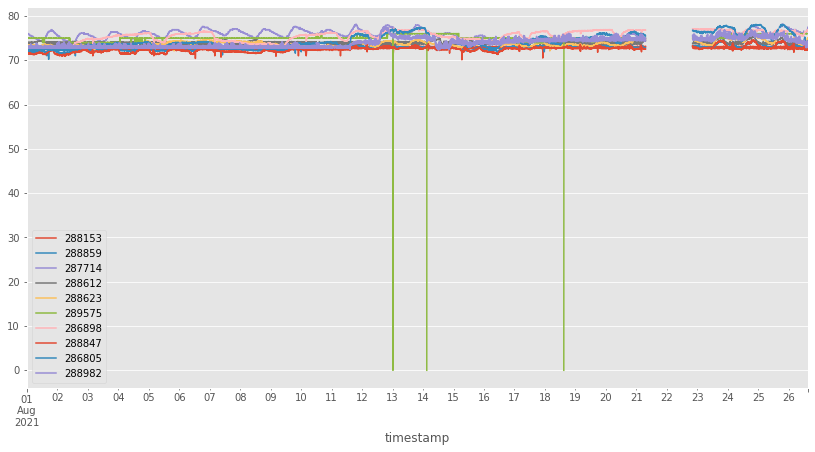

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot') # set figure style
plt.rcParams["figure.figsize"] = (14,7) # set figure size

minute_data.plot()

It's pretty hard to see the bulk of the data because of those major outliers.

<img src="https://i.imgflip.com/1aafs8.jpg"/>

Let's zoom in a bit:

(68.0, 80.0)

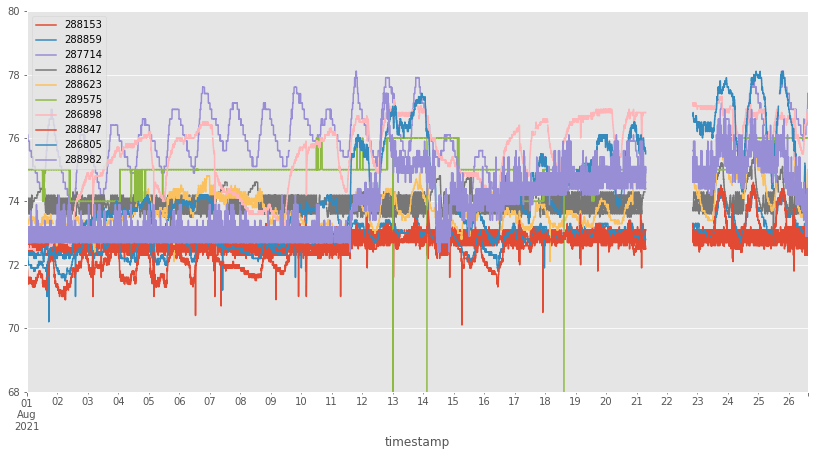

In [17]:
minute_data.plot()
plt.ylim(68,80)

At a few spots we can see discontinuities, but the main thing that jumps out is that big swath of missing data for all sensors, between 8/20 and 8/24. A heatmap is also very useful here.

<AxesSubplot:xlabel='timestamp'>

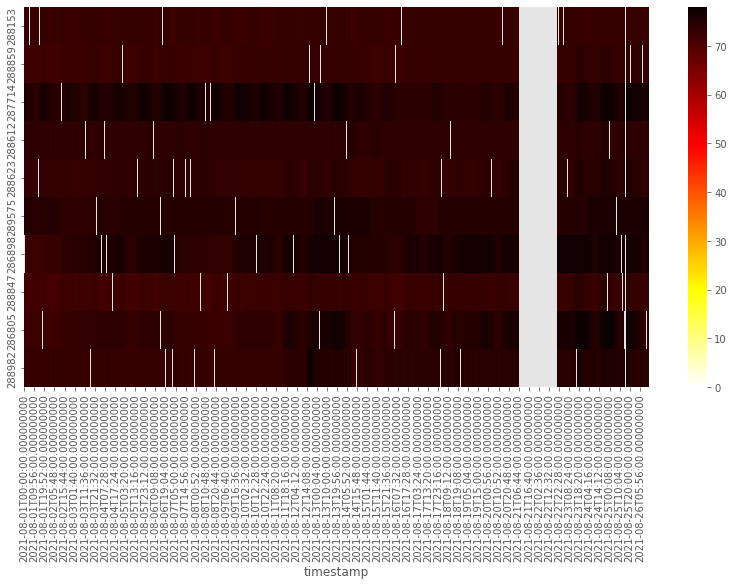

In [18]:
sns.heatmap(minute_data.T, cmap="hot_r")

This shows some of the missing data a bit more clearly, especially some of the smaller sections of missing data that didn't show so well in the lineplot.

Deciding what to do about missing data is a critical step in the process. If we simply downsample to a large enough interval, as we did in [the last notebook](https://github.com/onboard-data/notebooks/blob/main/03_time-series-analysis.ipynb), all those issues will "go away". Remember what we did last time:

<AxesSubplot:xlabel='timestamp'>

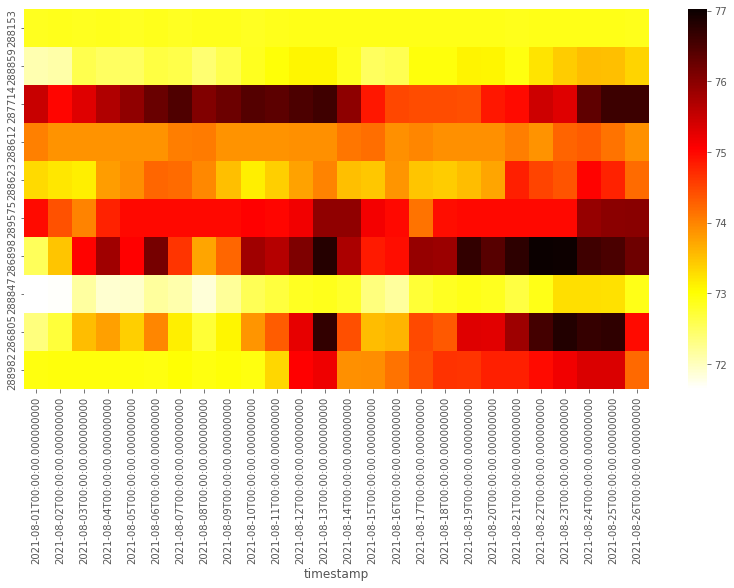

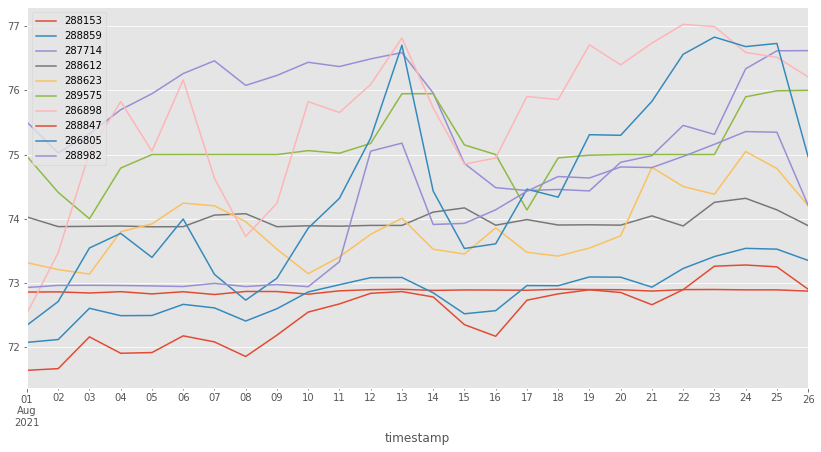

In [19]:
hourly_data = data.reset_index().resample('D', on='timestamp').mean()
sns.heatmap(hourly_data.T, cmap="hot_r")
hourly_data.plot()

But, this is only helpful if we don't want to know anything that's going on on a timescale less than a day.

Instead, though, we probably want to deal with the data at a smaller timescale, so, from here on out, we will consider different ways to fill in that data.

Before moving on to some of those techniques, it's worth noting that having a bunch of sensors all missing data for an identical, prolonged period suggests some other sort of problem that would be worth tracking down. We could dig in to other sensors, equipment, building logs, internet downtime, etc., to see why we're missing data for these sensors over a 2 day period. But, for now, let's just pretend all we want to do is fill that data in.

### Linear interpolation

As a first pass, we can simply use linear interpolation, using pandas' built-in `interpolation()` method. This fills in a missing data point by calculating the point along the straight line between the points preceding and following. This is a pretty good method, especially for those situations where only the stray data point is missing.

<AxesSubplot:xlabel='timestamp'>

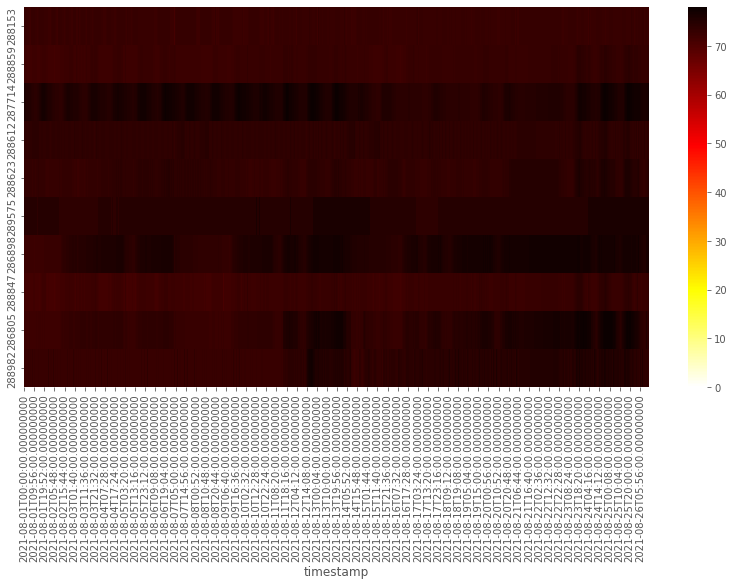

In [20]:
linear_interpolation = minute_data.interpolate()

sns.heatmap(linear_interpolation.T, cmap="hot_r")

Let's look at the lineplot again:

(68.0, 80.0)

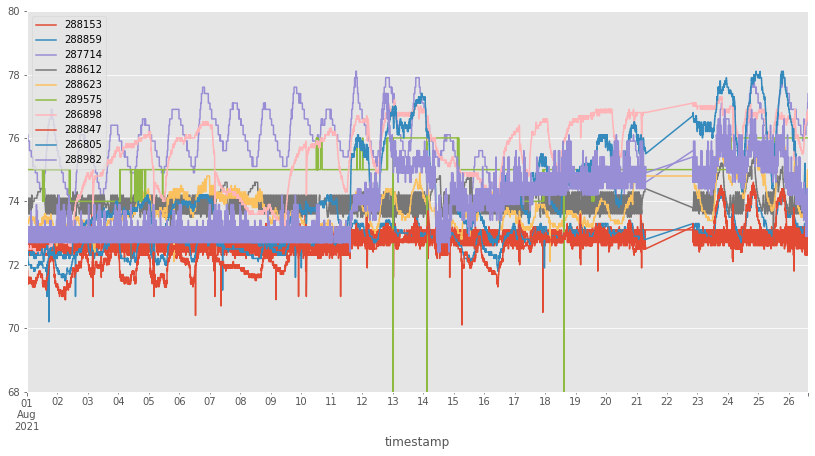

In [21]:
linear_interpolation.plot()
plt.ylim(68,80)

And that's it. You've done it. Notebook over.

<img src="https://i.giphy.com/9Tnzp6mvFMibjyYA1v.gif" />

Ok, fine, let's get a bit nitpicky. The lineplot does a good job of showing that this may not be the best way to fill in that big gap of data between the 21st and 24th, as it's fairly unrealistic. On the one hand, it's certainly better than nothing, but given the cyclic nature of this temperature data, having two days' worth of data (2 days * 24 hours * 60 minutes = ~2880 data points) as just straight lines doesn't seem like a very realistic representation of what might have gone on there.

### Forecasting for Imputation

There are other more sophisticated methods that will probably serve us well here. One example that is very easy to use is Prophet, which offers a host of super useful parameters for building timeseries forecasts/predictions. To consider this method, we first have to install the module.

In [23]:
!pip install prophet
!pip install plotly # plotly is required for interactive graphing with prophet

Let's first look at one of the sensors that gives strong cyclicity to see how well the model handles it.

<AxesSubplot:xlabel='timestamp'>

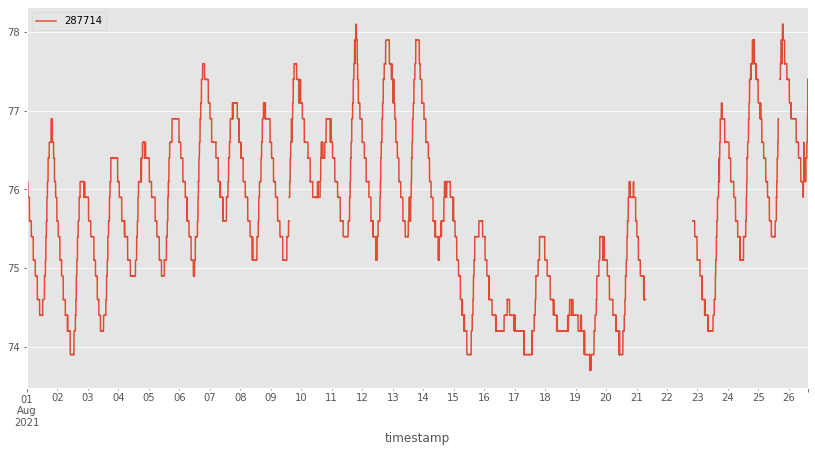

In [24]:
minute_data['287714'].to_frame().plot()

To build a [Prophet model](https://facebook.github.io/prophet/docs/quick_start.html), we first have to specify some parameters. For the current data, we can see some cyclicity pretty clearly at the scale of a single day, and assume there could be some cyclicity at the level of weeks. Since our data does not span past a month, we ignore the other seasonality parameters. Finally, we give interval_width of 0.95, which gives uncertainty bounds based on the model.

In [6]:
from prophet import Prophet

# instantiate the model
model = Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True)

# get the data in the format Prophet wants
single_sensor_data = minute_data['287714'].to_frame() # choose just one of our sensors to predict
single_sensor_data = single_sensor_data.rename(columns = {'287714' : 'y'})
single_sensor_data['ds'] = single_sensor_data.index
single_sensor_data['ds'] = single_sensor_data['ds'].dt.tz_localize(None) # drop timezone

In [7]:
model.fit(single_sensor_data)

15:27:25 - cmdstanpy - INFO - Chain [1] start processing
15:27:46 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
forecast = model.predict(single_sensor_data)

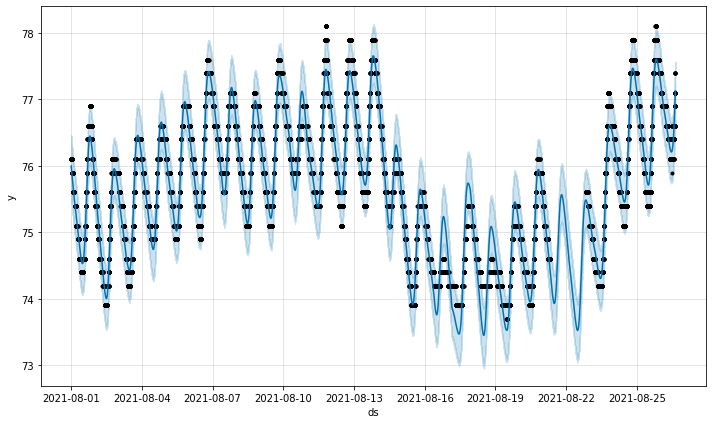

In [9]:
x = model.plot(forecast)

Looking at this plot (where black dots are the actual data points, and blue lines are the model's predictions), we see the model seems to have done a rather great job of filling in the data -- much better than the linear interpolation.

<img src="https://i.imgflip.com/6yog5l.jpg" style="width:60%"/>

Assuming we want to move forward with using this model-imputed data, we can merge the predicted and original data together, and make a new column that fills in the `NaN`s of the original data (the `y` column) with a value from the prediction (the `yhat` column).

Text(0.5, 1.0, 'Sensor with imputed data')

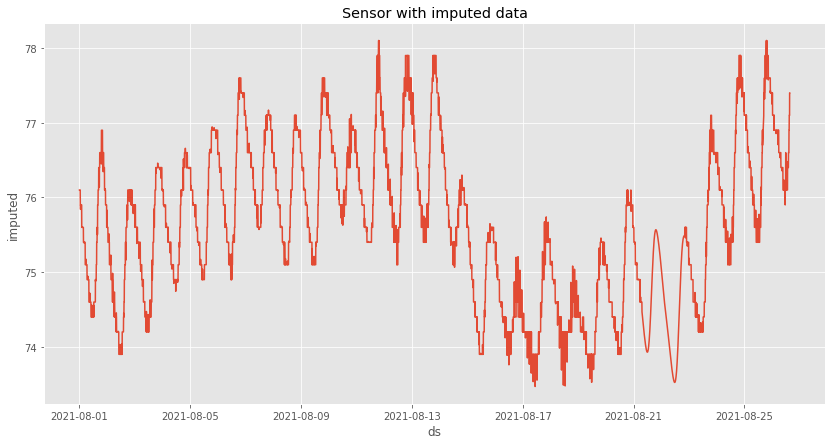

In [29]:
merged = pd.merge(single_sensor_data, forecast[['ds','yhat', 'yhat_lower','yhat_upper']], on="ds") # merge data and prediction on the shared timestamp column

# if there's a NaN in the og data, insert that prophet forecast baybeee
merged['imputed'] = merged.apply(lambda row: row['yhat'] if np.isnan(row['y']) else row['y'], axis=1) 
sns.lineplot(data=merged, x='ds', y='imputed')

plt.title('Sensor with imputed data')

#### Model Performance

So far, we've only generally said the model looks like it's done well at matching the actual data, but let's put our money where our mouth is, and actually quantify that.

##### Mean Absolute Error

Let's look at model performance by getting the mean absolute error, i.e., on average how far off the model was from the data.

In [30]:
merged['absolute_error'] = np.absolute(merged['y'] - merged['yhat'])
mae = np.mean(merged.absolute_error)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.16950811241409378


This means that, on average, the model was off by 0.17 degrees Fahrenheit, which is pretty accurate.

##### R<sup>2</sup>

We can also look at R<sup>2</sup>, a measure commonly used for regression models, to see how well the model fits the actual data.

In [31]:
from sklearn.metrics import r2_score

rsq_df = merged[merged.y.notnull()] # drop the NaNs because r2_score doesn't like them

print(f'R-squared = {round(r2_score(rsq_df["y"], rsq_df["yhat"]), 2)}')

R-squared = 0.95


This R-squared value essentially means that, disregarding the NaNs, the variability in the model prediction (y-hat) can account for 95% of the variability in the data (y). That's a pretty good model. After getting these model performance metrics, let's plot the prediction over the original data, to see how well they fit.

<AxesSubplot:>

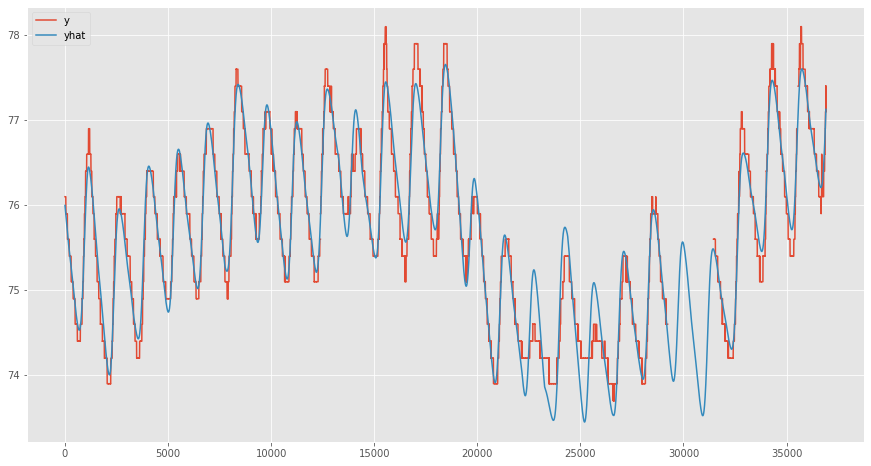

In [32]:
merged[['y', 'yhat']].plot(figsize=(15,8))

### Make a function to do a model for all sensors....

Now, for completeness, let's run the model over all the sensors and see what those predictions look like.

In [49]:
def make_model_forecast(col):
    single_sensor_data = col.to_frame().rename({col.name : 'y'}, axis=1)
    single_sensor_data['ds'] = single_sensor_data.index
    single_sensor_data['ds'] = single_sensor_data['ds'].dt.tz_localize(None) # drop timezone

    model = Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True)
    model.fit(single_sensor_data)

    forecast = model.predict(single_sensor_data)

    merged = pd.merge(single_sensor_data, forecast[['ds','yhat', 'yhat_lower','yhat_upper']])
        
    return(forecast['yhat'])


all_sensors_forecast = minute_data.apply(make_model_forecast).set_index(pd.Index(minute_data.index), 'timestamp') # reattach the index

10:16:49 - cmdstanpy - INFO - Chain [1] start processing
10:16:54 - cmdstanpy - INFO - Chain [1] done processing
10:17:06 - cmdstanpy - INFO - Chain [1] start processing
10:17:25 - cmdstanpy - INFO - Chain [1] done processing
10:17:37 - cmdstanpy - INFO - Chain [1] start processing
10:17:58 - cmdstanpy - INFO - Chain [1] done processing
10:18:09 - cmdstanpy - INFO - Chain [1] start processing
10:18:33 - cmdstanpy - INFO - Chain [1] done processing
10:18:45 - cmdstanpy - INFO - Chain [1] start processing
10:19:11 - cmdstanpy - INFO - Chain [1] done processing
10:19:25 - cmdstanpy - INFO - Chain [1] start processing
10:19:36 - cmdstanpy - INFO - Chain [1] done processing
10:19:52 - cmdstanpy - INFO - Chain [1] start processing
10:20:17 - cmdstanpy - INFO - Chain [1] done processing
10:20:29 - cmdstanpy - INFO - Chain [1] start processing
10:20:47 - cmdstanpy - INFO - Chain [1] done processing
10:20:59 - cmdstanpy - INFO - Chain [1] start processing
10:21:38 - cmdstanpy - INFO - Chain [1]

<AxesSubplot:xlabel='timestamp'>

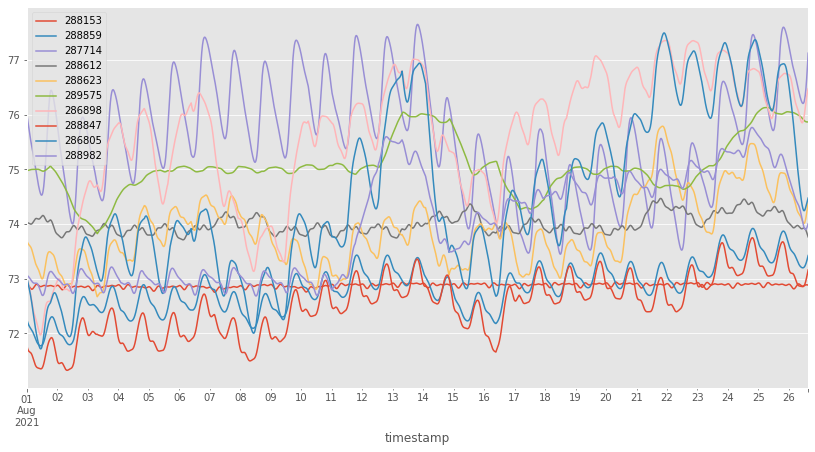

In [51]:
all_sensors_forecast.plot()

There you have it, a forecast of all the sensors, and if we want, we can repeat some of the steps above and merge these forecasts with the original data to impute those values for the timestamps with missing data.

## Conclusion

So far, we looked at how to manage timestamp resolution issues in a relatively rigorous way, and how to impute missing data. This also gave us our first look at Prophet, a timeseries forecasting and modeling procedure that we will revisit in later notebooks. In conclusion, the great American president Abraham Lincoln once said "data science is dope" before nailing a fakie heel flip on his longboard, and this notebook truly embodies that sentiment. 

In future notebooks we’ll be talking about measuring timeseries sparsity, detecting outliers and anomalies, and looking more at Prophet’s forecasting abilities.